# Notebook 05: Clustering & Pseudo-Labeling (1-Hour Aggregates)

In this notebook, we demonstrate how to generate **pseudo-labels** for air quality classification using clustering methods.  
The goal is to create *unsupervised groups* from the **1-hour aggregated AoT sensor data** that can later support supervised modeling.  

We apply **DBSCAN** and **KMeans** on pollutant + environmental features, then save the results as  
`pseudo_labels_dbscan_kmeans_1hour.csv` (included in the dataset folder).  

This workflow provides reproducible evidence for how pseudo-labels were created in the research pipeline.



In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load the Aggregated Data

We use the **1-hour aggregated file** (`aot_aggregated_1hour.csv`).  
This file provides stable averages over longer windows, making it suitable for clustering and pseudo-label generation.  

In [3]:
# Load 1-hour aggregated data
df = pd.read_csv("../data/aggregated/aot_aggregated_1hour.csv")
print(df.shape)
df.head()

(10091, 5)


,timestamp,node_id,sensor,parameter,value_hrf
0,2020-01-12 00:00:00,001e0610ee36,hih6130,humidity,100.000000
1,2020-01-12 00:00:00,001e0610ee36,hih6130,temperature,125.010000
2,2020-01-12 00:00:00,001e0610ee36,htu21d,humidity,118.990000
3,2020-01-12 00:00:00,001e0610ee36,htu21d,temperature,128.860000
4,2020-01-12 00:00:00,001e0610ee43,co,concentration,-0.437003


## 2. Preprocess Features

We select pollutant and environmental variables and transform the dataset into  
a **pivot table** where rows represent `(timestamp, node_id)` and columns represent `(sensor, parameter)`.  

Missing values are filled with zeros before clustering.

In [4]:
# Define target features
pollutants = ["co", "no2", "so2", "pm25"]
env_vars = ["temperature", "humidity", "pressure"]

df_subset = df[df["parameter"].isin(pollutants + env_vars)].copy()

# Pivot table: rows = timestamp + node, cols = sensor-parameter
df_pivot = df_subset.pivot_table(
    index=["timestamp","node_id"],
    columns=["sensor","parameter"],
    values="value_hrf"
).fillna(0)

print(df_pivot.shape)
df_pivot.head()

(1924, 4)


sensor                               hih6130                  htu21d  \
parameter                           humidity temperature    humidity   
timestamp           node_id                                            
2020-01-12 00:00:00 001e0610ee36  100.000000  125.010000  118.990000   
                    001e0610ee43   29.881429   23.907500   87.323214   
                    001e0610f05c   65.010000   17.570000  118.990000   
                    001e06113107   67.204015    5.088832   95.231533   
                    001e06113ad8   35.240320   15.911920   -6.000000   

sensor                                        
parameter                        temperature  
timestamp           node_id                   
2020-01-12 00:00:00 001e0610ee36  128.860000  
                    001e0610ee43    0.765000  
                    001e0610f05c    0.003286  
                    001e06113107    0.091460  
                    001e06113ad8   -1.677953

## 3. Normalize the Data

We apply **StandardScaler** to normalize features before clustering.  
This ensures each variable contributes equally, regardless of scale.  

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(df_pivot)

## 4. Apply Clustering Algorithms

We use two clustering approaches:  

- **KMeans (k=5):** Partitions data into a fixed number of clusters.  
- **DBSCAN (eps=2.0, min_samples=10):** Density-based clustering that discovers arbitrary-shaped clusters.  

Both cluster assignments are saved as new columns in the pivot table.

In [6]:
# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_pivot["kmeans_label"] = kmeans.fit_predict(X)

# DBSCAN clustering
dbscan = DBSCAN(eps=2.0, min_samples=10)
df_pivot["dbscan_label"] = dbscan.fit_predict(X)

df_pivot.head()

sensor                               hih6130                  htu21d  \
parameter                           humidity temperature    humidity   
timestamp           node_id                                            
2020-01-12 00:00:00 001e0610ee36  100.000000  125.010000  118.990000   
                    001e0610ee43   29.881429   23.907500   87.323214   
                    001e0610f05c   65.010000   17.570000  118.990000   
                    001e06113107   67.204015    5.088832   95.231533   
                    001e06113ad8   35.240320   15.911920   -6.000000   

sensor                                       kmeans_label dbscan_label  
parameter                        temperature                            
timestamp           node_id                                             
2020-01-12 00:00:00 001e0610ee36  128.860000            1            0  
                    001e0610ee43    0.765000            2            0  
                    001e0610f05c    0.003286            0            0  
                    001e06113107    0.091460            0            0  
                    001e06113ad8   -1.677953            4            0

## 5. Save Pseudo-Labels

We now save the clustering results to  
`../data/aggregated/pseudo_labels_dbscan_kmeans_1hour.csv`.  

This file can be used for downstream supervised modeling.  

In [7]:
out_path = "../data/aggregated/pseudo_labels_dbscan_kmeans_1hour.csv"
df_pivot.reset_index().to_csv(out_path, index=False)
print(f"Saved clustering results to {out_path}")

Saved clustering results to ../data/aggregated/pseudo_labels_dbscan_kmeans_1hour.csv


## 6. Visualize Clustering (Optional)

To get an intuition of clustering behavior, we reduce the feature space to **2D PCA coordinates**  
and plot clusters as colored scatterplots.

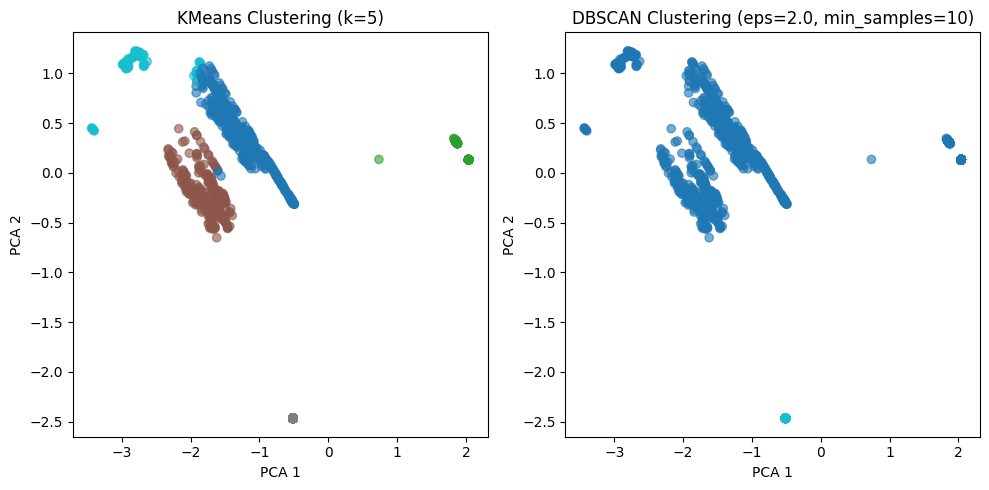

In [8]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.figure(figsize=(10,5))

# KMeans visualization
plt.subplot(1,2,1)
plt.scatter(coords[:,0], coords[:,1], c=df_pivot["kmeans_label"], cmap="tab10", alpha=0.6)
plt.title("KMeans Clustering (k=5)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# DBSCAN visualization
plt.subplot(1,2,2)
plt.scatter(coords[:,0], coords[:,1], c=df_pivot["dbscan_label"], cmap="tab10", alpha=0.6)
plt.title("DBSCAN Clustering (eps=2.0, min_samples=10)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

## 7. Notes

- The number of clusters (`k=5` for KMeans) was chosen to align with AQI categories,  
  but this is adjustable depending on the research question.  
- DBSCAN may label some points as `-1` (outliers).  
- The generated pseudo-labels are exploratory and **not ground truth**,  
  but they provide a useful scaffold for supervised model training.  

> **Disclaimer:**  
> The clustering and visualization steps in this notebook are shown on a **smaller subset of the AoT dataset** for demonstration purposes.  
> In the actual research paper, clustering was performed on the **full dataset**, and the resulting plots were further refined (color palettes, axis formatting, annotations) to ensure readability and publication quality.  
> The workflow here is representative of the process, but the exact outputs may differ from those presented in the paper.